---
### Imports

In [1]:
import pandas as pd
import torch
from torchmetrics import Accuracy, F1Score
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from matplotlib import pyplot as plt
from tqdm import tqdm
from prettytable import PrettyTable

W0622 23:08:23.129000 11212 torch\distributed\elastic\multiprocessing\redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


---
### Load Dataset
##### Train:

In [2]:
data_frame_train = pd.read_csv('./dataset/train.csv')
x = data_frame_train.drop('price_range', axis=1)
y = data_frame_train['price_range']

In [3]:
x

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi
0,842,0,2.2,0,1,0,7,0.6,188,2,2,20,756,2549,9,7,19,0,0,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,6,905,1988,2631,17,3,7,1,1,0
2,563,1,0.5,1,2,1,41,0.9,145,5,6,1263,1716,2603,11,2,9,1,1,0
3,615,1,2.5,0,0,0,10,0.8,131,6,9,1216,1786,2769,16,8,11,1,0,0
4,1821,1,1.2,0,13,1,44,0.6,141,2,14,1208,1212,1411,8,2,15,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,794,1,0.5,1,0,1,2,0.8,106,6,14,1222,1890,668,13,4,19,1,1,0
1996,1965,1,2.6,1,0,0,39,0.2,187,4,3,915,1965,2032,11,10,16,1,1,1
1997,1911,0,0.9,1,1,1,36,0.7,108,8,3,868,1632,3057,9,1,5,1,1,0
1998,1512,0,0.9,0,4,1,46,0.1,145,5,5,336,670,869,18,10,19,1,1,1


In [4]:
y

0       1
1       2
2       2
3       2
4       1
       ..
1995    0
1996    2
1997    3
1998    0
1999    3
Name: price_range, Length: 2000, dtype: int64

In [5]:
x_train, x_valid, y_train, y_valid = train_test_split(x, y, train_size=0.7, random_state=42)

In [6]:
x_train

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi
836,902,1,0.6,1,0,0,63,0.7,122,5,14,364,1360,3654,18,8,15,0,1,1
575,1197,1,0.5,1,9,0,20,0.1,129,5,10,214,1710,2885,19,7,14,1,1,1
557,1519,0,2.1,0,0,0,32,0.7,200,1,10,168,1239,2912,11,10,15,1,1,0
1235,1971,1,0.5,1,0,0,40,0.3,186,7,19,485,922,571,8,7,17,1,1,0
1360,882,0,0.7,1,9,1,28,0.2,151,6,16,248,884,751,19,11,8,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1130,1975,1,1.9,1,2,0,31,0.9,151,1,17,775,1607,3022,13,5,19,0,0,1
1294,589,1,0.5,0,1,1,59,0.7,146,8,4,759,1858,362,16,10,6,1,1,1
860,1829,1,0.5,0,0,1,15,0.4,160,5,7,729,1267,2080,16,11,12,1,0,1
1459,1927,0,0.9,1,3,0,11,0.4,190,8,12,491,1506,2916,16,11,18,0,1,1


---
### Preprocessing

In [7]:
x_train = torch.FloatTensor(x_train.values)
y_train = torch.LongTensor(y_train.values)

In [8]:
x_valid = torch.FloatTensor(x_valid.values)
y_valid = torch.LongTensor(y_valid.values)

---
### Normalization (Standardization)

In [9]:
mu = x_train.mean(dim=0)
std = x_train.std(dim=0)
x_train = (x_train - mu) / std
x_valid = (x_valid - mu) / std

---
### Dataloader

In [10]:
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=600, shuffle=True)

valid_dataset = TensorDataset(x_valid, y_valid)
valid_loader = DataLoader(valid_dataset, batch_size=800, shuffle=False)

---
### Define Model

##### Device

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

##### Model

In [12]:
def define_model():
    """
    Defining the model with this method.
    :return: The model that convert to device (CUDA if accessible and CPU if not)
    """

    num_feats = 20
    out_feats = 4
    h1 = 64
    h2 = 32

    model = torch.nn.Sequential(torch.nn.Linear(num_feats, h1),
                                torch.nn.ReLU(),
                                # torch.nn.Dropout(0.5),
                                torch.nn.Linear(h1, h2),
                                torch.nn.ReLU(),
                                torch.nn.Linear(h2, out_feats))
    model.to(device)
    return model

---
### Loss Function

In [13]:
loss_fn = torch.nn.CrossEntropyLoss()

---
### AverageMeter

In [14]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

---
### Methods of train and validate model:

In [15]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, epoch, disable_log=False):
    """
    Train one epoch of your model with this method.
    :param model: The model to be trained.
    :param train_loader: The data loader of the training data.
    :param loss_fn: The loss function.
    :param optimizer: The optimizer.
    :param epoch: The current epoch.
    :param disable_log: Pass it True to disable log while training.
    :return: The trained model of that epoch, the loss of train, the accuracy of train and the f1-score of train
    """

    model.train()
    loss_train = AverageMeter()
    acc_train = Accuracy(task="multiclass", num_classes=4).to(device)
    f1_train = F1Score(task="multiclass", num_classes=4).to(device)

    with tqdm(train_loader, unit='batch', disable=disable_log) as t_loader:
        for data, target in t_loader:
            data = data.to(device)
            target = target.to(device)

            predict = model(data)
            loss = loss_fn(predict.squeeze(), target)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            loss_train.update(loss.item())
            acc_train(predict, target)
            f1_train(predict, target)

            t_loader.set_description(f"Epoch: {epoch}")
            t_loader.set_postfix(loss=loss_train.avg,
                                 accuracy=f"{(acc_train.compute().cpu().item() * 100):.4}%",
                                 f1=f"{(f1_train.compute().cpu().item() * 100):.4}%")

    return model, loss_train.avg, acc_train.compute(), f1_train.compute()

In [16]:
def valid_one_epoch(model, valid_loader, loss_fn):
    """
    Validate one epoch of your model with this method.
    :param model: The model to be validated.
    :param valid_loader: The data loader of the validation data.
    :param loss_fn: The loss function.
    :return: The loss of validation, the accuracy of validation and the f1-score of validation
    """

    model.eval()
    with torch.no_grad():
        loss_valid = AverageMeter()
        acc_valid = Accuracy(task="multiclass", num_classes=4).to(device)
        f1_valid = F1Score(task="multiclass", num_classes=4).to(device)
        for data, target in valid_loader:
            data = data.to(device)
            target = target.to(device)

            predict = model(data)
            loss = loss_fn(predict.squeeze(), target)

            loss_valid.update(loss.item())
            acc_valid(predict, target)
            f1_valid(predict, target)

    return loss_valid.avg, acc_valid.compute(), f1_valid.compute()

---
#### Select best Learning Rate and Weight decay

In [17]:
list_for_table_loss_train = []
list_for_table_acc_train = []
list_weight_decays = ['(⬇️LR) (WD➡️)', 0, 1e-4, 1e-5, 1e-6]

In [18]:
for confidence in [1, 0.1, 0.01, 0.001]:
    for lr in [0.1, 0.15, 0.2, 0.25, 0.3]:
        temp_list_loss_train = [round(lr * confidence, 5)]
        temp_list_acc_train = [round(lr * confidence, 5)]

        for wd in [0., 1e-4, 1e-5, 1e-6]:
            model = define_model()
            # optimizer = torch.optim.SGD(model.parameters(), lr=(lr * confidence), weight_decay=wd)
            # optimizer = torch.optim.RMSprop(model.parameters(), alpha=0.99, lr=(lr * confidence), weight_decay=wd)
            optimizer = torch.optim.Adam(model.parameters(), lr=(lr * confidence), weight_decay=wd, betas=(0.9, 0.999))

            print(f'LR={lr * confidence}, WD={wd}')
            for epoch in range(5):
                model, loss_train, acc_train, _ = train_one_epoch(model=model,
                                                                  train_loader=train_loader,
                                                                  loss_fn=loss_fn,
                                                                  optimizer=optimizer,
                                                                  epoch=epoch,
                                                                  disable_log=True)
                if epoch == 4:
                    temp_list_loss_train.append(round(loss_train, 3))
                    temp_list_acc_train.append(f"{(acc_train.item() * 100):.3}%")

        list_for_table_loss_train.append(temp_list_loss_train)
        list_for_table_acc_train.append(temp_list_acc_train)

LR=0.1, WD=0.0
LR=0.1, WD=0.0001
LR=0.1, WD=1e-05
LR=0.1, WD=1e-06
LR=0.15, WD=0.0
LR=0.15, WD=0.0001
LR=0.15, WD=1e-05
LR=0.15, WD=1e-06
LR=0.2, WD=0.0
LR=0.2, WD=0.0001
LR=0.2, WD=1e-05
LR=0.2, WD=1e-06
LR=0.25, WD=0.0
LR=0.25, WD=0.0001
LR=0.25, WD=1e-05
LR=0.25, WD=1e-06
LR=0.3, WD=0.0
LR=0.3, WD=0.0001
LR=0.3, WD=1e-05
LR=0.3, WD=1e-06
LR=0.010000000000000002, WD=0.0
LR=0.010000000000000002, WD=0.0001
LR=0.010000000000000002, WD=1e-05
LR=0.010000000000000002, WD=1e-06
LR=0.015, WD=0.0
LR=0.015, WD=0.0001
LR=0.015, WD=1e-05
LR=0.015, WD=1e-06
LR=0.020000000000000004, WD=0.0
LR=0.020000000000000004, WD=0.0001
LR=0.020000000000000004, WD=1e-05
LR=0.020000000000000004, WD=1e-06
LR=0.025, WD=0.0
LR=0.025, WD=0.0001
LR=0.025, WD=1e-05
LR=0.025, WD=1e-06
LR=0.03, WD=0.0
LR=0.03, WD=0.0001
LR=0.03, WD=1e-05
LR=0.03, WD=1e-06
LR=0.001, WD=0.0
LR=0.001, WD=0.0001
LR=0.001, WD=1e-05
LR=0.001, WD=1e-06
LR=0.0015, WD=0.0
LR=0.0015, WD=0.0001
LR=0.0015, WD=1e-05
LR=0.0015, WD=1e-06
LR=0.002, WD

#### Show tabular data

In [19]:
def show_tabular_data(field_names, rows):
    """
    Show data tabular with PrettyTable.
    :param field_names: The names of header of the table.
    :param rows: The data rows.
    :return: None (Print the table in console)
    """

    table = PrettyTable()
    table.align = "c"
    table.field_names = field_names
    table.add_rows(rows)
    print(table)

##### Table loss train

In [20]:
show_tabular_data(field_names=list_weight_decays, rows=list_for_table_loss_train)

+---------------+-------+--------+-------+-------+
| (⬇️LR) (WD➡️) |   0   | 0.0001 | 1e-05 | 1e-06 |
+---------------+-------+--------+-------+-------+
|      0.1      | 0.253 | 0.404  | 0.509 | 0.233 |
|      0.15     | 0.589 | 0.492  | 1.242 | 0.583 |
|      0.2      | 0.707 | 0.659  | 0.855 | 0.539 |
|      0.25     | 1.287 |  1.4   | 1.312 | 0.773 |
|      0.3      | 1.372 |  1.13  | 1.256 | 1.363 |
|      0.01     | 0.604 | 0.636  | 0.599 | 0.599 |
|     0.015     | 0.366 | 0.422  | 0.371 | 0.437 |
|      0.02     | 0.292 | 0.289  | 0.314 |  0.33 |
|     0.025     |  0.25 | 0.209  | 0.194 |  0.21 |
|      0.03     | 0.165 | 0.229  | 0.193 | 0.154 |
|     0.001     |  1.34 | 1.343  | 1.353 | 1.344 |
|     0.0015    | 1.321 | 1.336  | 1.329 | 1.353 |
|     0.002     | 1.277 |  1.31  | 1.262 | 1.287 |
|     0.0025    | 1.283 | 1.214  | 1.249 | 1.236 |
|     0.003     | 1.181 | 1.195  | 1.196 | 1.215 |
|     0.0001    | 1.385 | 1.395  | 1.389 | 1.386 |
|    0.00015    | 1.388 | 1.385

##### Table accuracy train

In [21]:
show_tabular_data(field_names=list_weight_decays, rows=list_for_table_acc_train)

+---------------+-------+--------+-------+-------+
| (⬇️LR) (WD➡️) |   0   | 0.0001 | 1e-05 | 1e-06 |
+---------------+-------+--------+-------+-------+
|      0.1      | 90.4% | 85.0%  | 76.2% | 90.9% |
|      0.15     | 75.9% | 78.8%  | 40.2% | 73.3% |
|      0.2      | 66.0% | 68.5%  | 59.1% | 82.8% |
|      0.25     | 25.6% | 23.8%  | 33.7% | 63.8% |
|      0.3      | 32.4% | 42.7%  | 34.2% | 28.1% |
|      0.01     | 81.3% | 80.8%  | 80.9% | 82.2% |
|     0.015     | 87.4% | 87.2%  | 88.7% | 86.6% |
|      0.02     | 90.4% | 91.3%  | 88.9% | 89.3% |
|     0.025     | 89.3% | 93.1%  | 94.1% | 93.0% |
|      0.03     | 93.1% | 90.9%  | 92.4% | 94.9% |
|     0.001     | 39.3% | 44.6%  | 37.5% | 40.6% |
|     0.0015    | 48.0% | 45.2%  | 46.9% | 45.9% |
|     0.002     | 49.4% | 52.4%  | 60.7% | 55.9% |
|     0.0025    | 52.1% | 57.3%  | 55.4% | 55.0% |
|     0.003     | 59.9% | 60.3%  | 57.4% | 59.9% |
|     0.0001    | 25.8% | 24.4%  | 25.1% | 25.5% |
|    0.00015    | 25.4% | 27.1%

---
### Optimizer

In [22]:
model = define_model()
model

Sequential(
  (0): Linear(in_features=20, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=4, bias=True)
)

In [23]:
optim_names = ['sgd', 'rms', 'adam']

In [24]:
# optim_name = optim_names[0]
# optimizer = torch.optim.SGD(model.parameters(),
#                             lr=0.3,
#                             # momentum=0.1,
#                             # nesterov=True,
#                             weight_decay=0.)

# optim_name = optim_names[1]
# optimizer = torch.optim.RMSprop(model.parameters(),
#                                 weight_decay=0,
#                                 lr=0.01,
#                                 alpha=0.99)

optim_name = optim_names[2]
optimizer = torch.optim.Adam(model.parameters(),
                             weight_decay=1e-6,
                             lr=0.03,
                             betas=(0.9, 0.999))

---
### Train

In [25]:
epochs = 300

In [26]:
hist_loss_train = []
hist_loss_valid = []

hist_acc_train = []
hist_acc_valid = []

hist_f1_train = []
hist_f1_valid = []

In [27]:
for epoch in range(epochs):
    model, loss_train, acc_train, f1_train = train_one_epoch(model=model,
                                                             train_loader=train_loader,
                                                             loss_fn=loss_fn,
                                                             optimizer=optimizer,
                                                             epoch=epoch,
                                                             disable_log=True)

    loss_valid, acc_valid, f1_valid = valid_one_epoch(model=model, valid_loader=valid_loader, loss_fn=loss_fn)

    hist_loss_train.append(loss_train)
    hist_loss_valid.append(loss_valid)

    hist_acc_train.append(acc_train.cpu())
    hist_acc_valid.append(acc_valid.cpu())

    hist_f1_train.append(f1_train.cpu())
    hist_f1_valid.append(f1_valid.cpu())

    print(f"Loss_valid: {loss_valid:.4}, Accuracy_valid: {(acc_valid * 100):.4}%, F1_valid: {(f1_valid * 100):.4}%")

Loss_valid: 1.023, Accuracy_valid: 62.33%, F1_valid: 62.33%
Loss_valid: 0.6041, Accuracy_valid: 74.33%, F1_valid: 74.33%
Loss_valid: 0.3659, Accuracy_valid: 82.33%, F1_valid: 82.33%
Loss_valid: 0.2621, Accuracy_valid: 87.0%, F1_valid: 87.0%
Loss_valid: 0.2916, Accuracy_valid: 86.5%, F1_valid: 86.5%
Loss_valid: 0.2871, Accuracy_valid: 89.0%, F1_valid: 89.0%
Loss_valid: 0.2956, Accuracy_valid: 88.33%, F1_valid: 88.33%
Loss_valid: 0.2636, Accuracy_valid: 89.83%, F1_valid: 89.83%
Loss_valid: 0.4078, Accuracy_valid: 87.83%, F1_valid: 87.83%
Loss_valid: 0.4026, Accuracy_valid: 89.0%, F1_valid: 89.0%
Loss_valid: 0.3232, Accuracy_valid: 89.33%, F1_valid: 89.33%
Loss_valid: 0.3663, Accuracy_valid: 90.33%, F1_valid: 90.33%
Loss_valid: 0.383, Accuracy_valid: 87.83%, F1_valid: 87.83%
Loss_valid: 0.3562, Accuracy_valid: 89.67%, F1_valid: 89.67%
Loss_valid: 0.3752, Accuracy_valid: 90.0%, F1_valid: 90.0%
Loss_valid: 0.4345, Accuracy_valid: 88.0%, F1_valid: 88.0%
Loss_valid: 0.3638, Accuracy_valid: 90

#### Plot method

In [ ]:
def plot_compares(epochs, values1, label1, values2, label2, x_label, y_label, figsize=(10, 10)):
    """
    Plot comparison curve.
    :param epochs: The number of epochs.
    :param values1: Values of first plot
    :param label1: Label of first plot
    :param values2: Values of second plot
    :param label2: Label of second plot
    :param x_label: Label of x axis
    :param y_label: Label of y axis
    :param figsize: Figure size
    :return: None (Show the plot)
    """

    fig, ax = plt.subplots(figsize=figsize)

    ax.plot(range(epochs), values1, 'r-', label=label1)
    ax.plot(range(epochs), values2, 'b-', label=label2)

    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.grid(True)
    ax.legend()

---
### Plot (Loss)

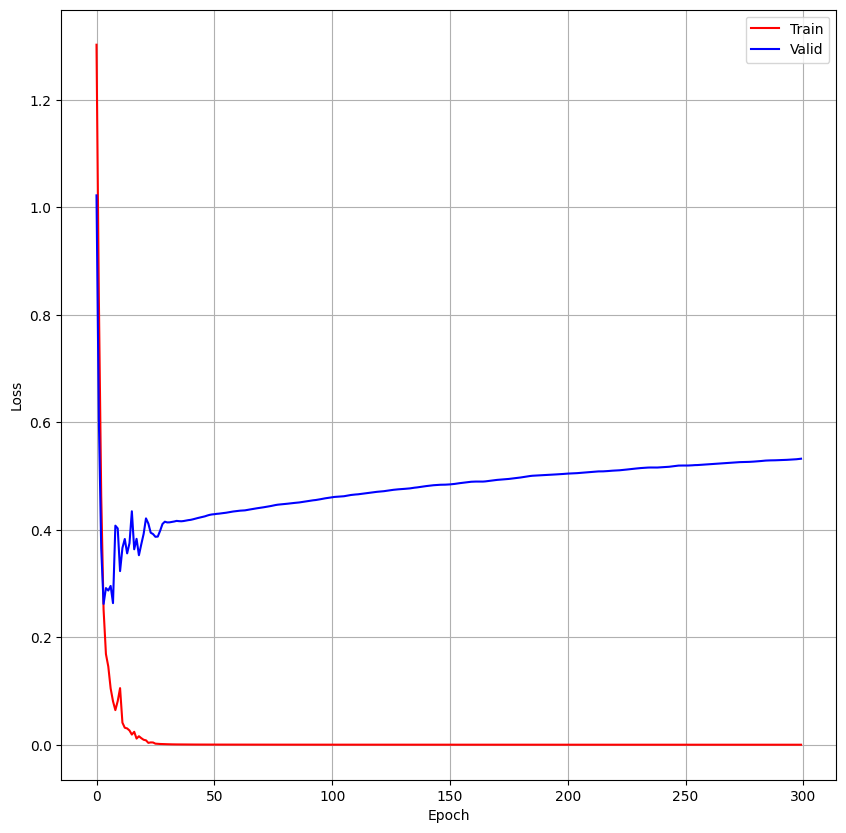

In [28]:
plot_compares(epochs=epochs,
              values1=hist_loss_train,
              label1='Train',
              values2=hist_loss_valid,
              label2='Valid',
              x_label='Epoch',
              y_label='Loss')

###  Plot (Accuracy)

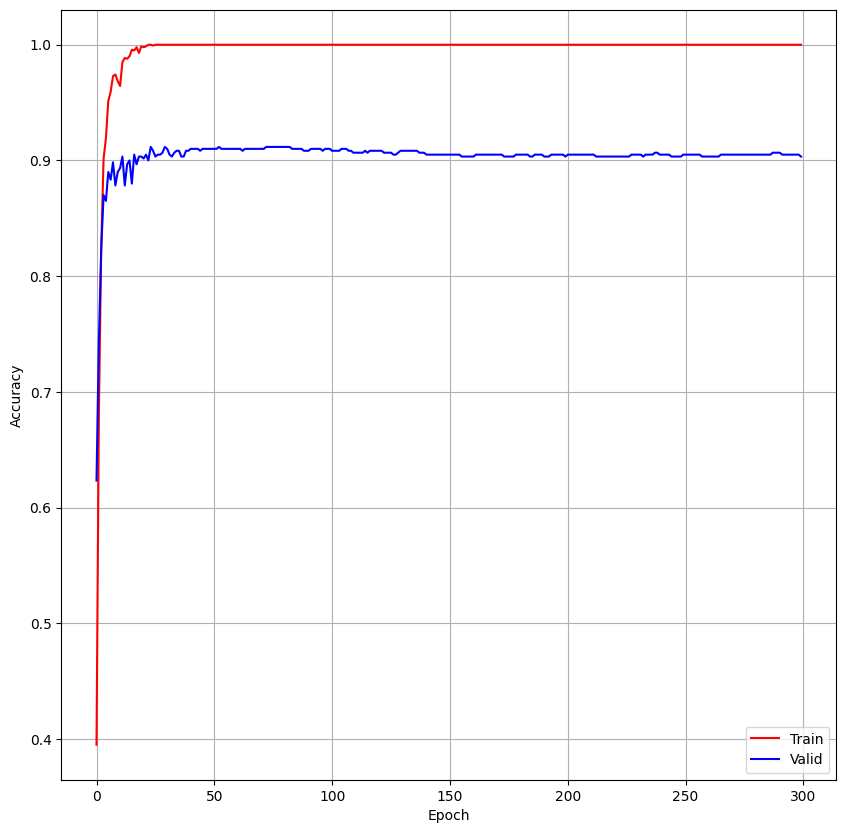

In [29]:
plot_compares(epochs=epochs,
              values1=hist_acc_train,
              label1='Train',
              values2=hist_acc_valid,
              label2='Valid',
              x_label='Epoch',
              y_label='Accuracy')

#### Plot (F1 Score)

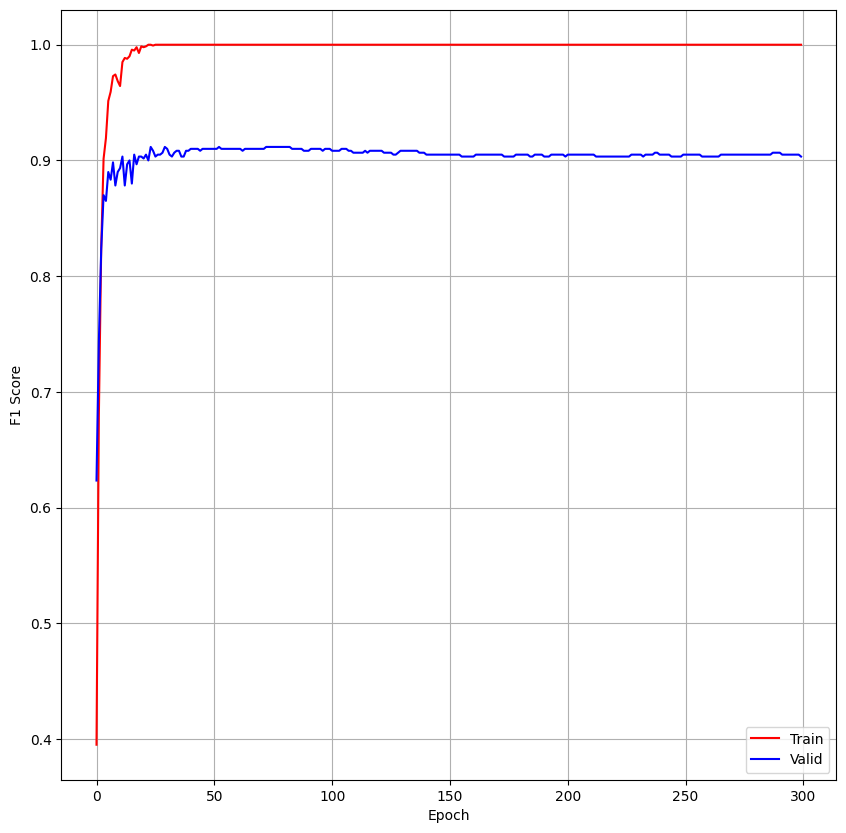

In [30]:
plot_compares(epochs=epochs,
              values1=hist_f1_train,
              label1='Train',
              values2=hist_f1_valid,
              label2='Valid',
              x_label='Epoch',
              y_label='F1 Score')

---
### Save Model

In [31]:
!mkdir save

A subdirectory or file save already exists.


In [32]:
# torch.save(model, './save/model.pt')

torch.save(torch.tensor(hist_acc_train), f'./save/{optim_name}_acc_train.pt')
torch.save(torch.tensor(hist_acc_valid), f'./save/{optim_name}_acc_valid.pt')

torch.save(torch.tensor(hist_loss_train), f'./save/{optim_name}_loss_train.pt')
torch.save(torch.tensor(hist_loss_valid), f'./save/{optim_name}_loss_valid.pt')

In [33]:
# torch.load('./save/model.pt', weights_only=False)

---
#### Comparing

In [34]:
def plot_lcs(x: str = 'loss' or 'acc', y: str = 'train' or 'valid'):
    """
    Plot the tables.
    :param x: choose from 'loss' or 'acc'
    :param y: choose from 'train' or 'valid'
    :return: plot the models.
    """

    plt.figure(figsize=(8, 6))
    for name in optim_names:
        z = torch.load(f'./save/{name}_{x}_{y}.pt')
        plt.plot(range(epochs), z, label=name)
        plt.xlabel('Epoch')
        plt.ylabel(f'{x}-{y}')
        plt.grid(True)
        plt.legend()

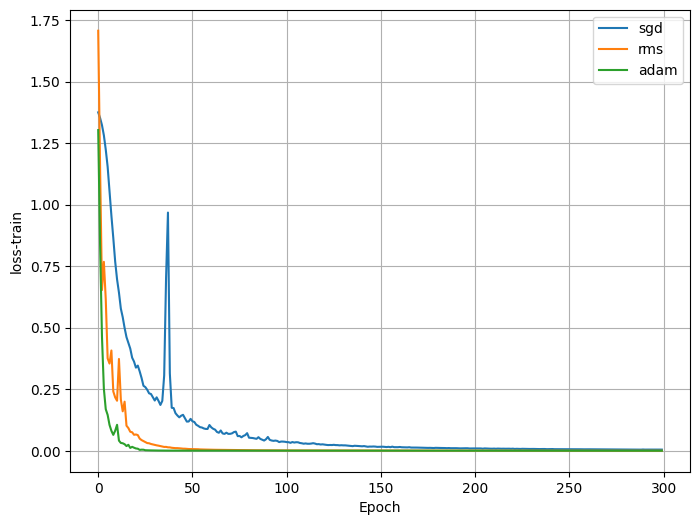

In [35]:
plot_lcs(x='loss', y='train')

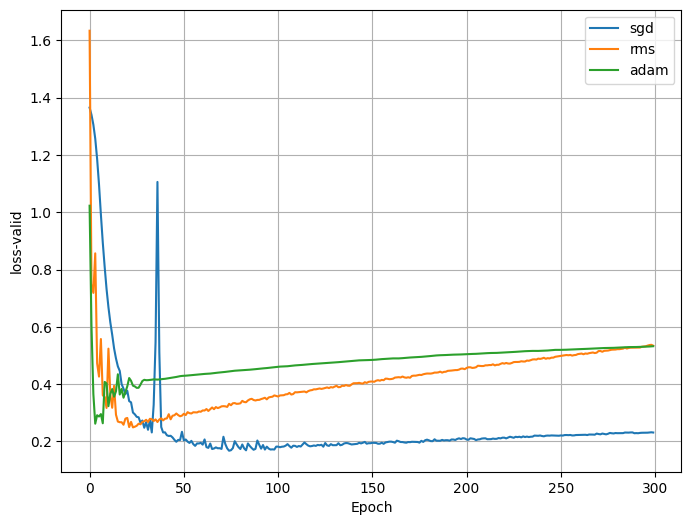

In [36]:
plot_lcs(x='loss', y='valid')

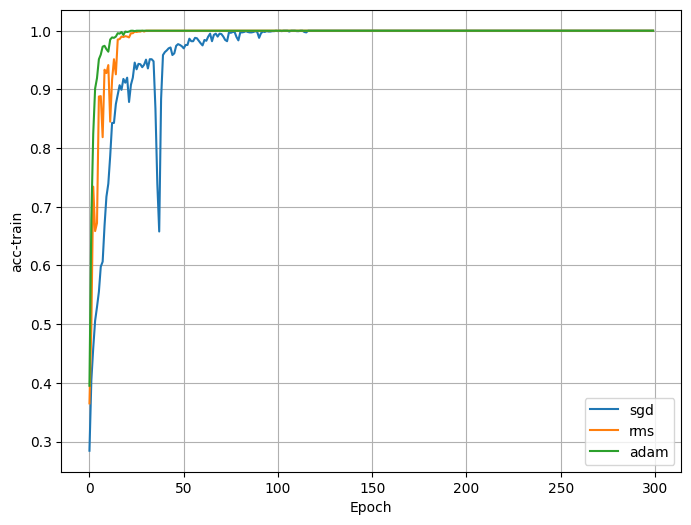

In [37]:
plot_lcs(x='acc', y='train')

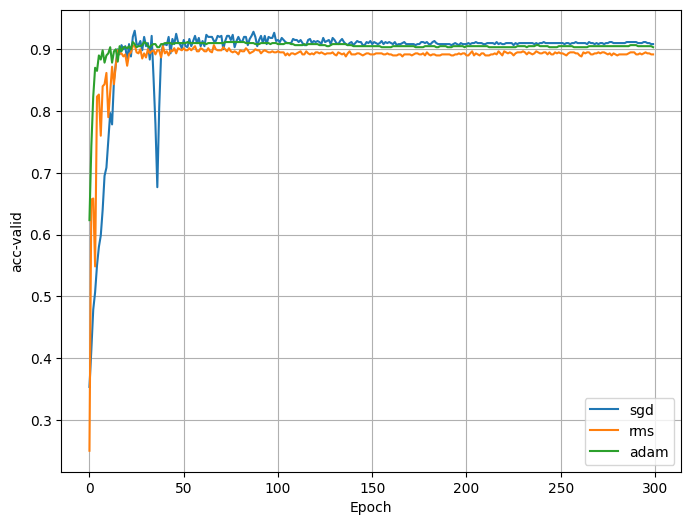

In [38]:
plot_lcs(x='acc', y='valid')